In [1]:
# code taken from source https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-956378644f90>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_json('drive/MyDrive/input/News_Category_Dataset_v3.json',lines=True)
beforeMay2018 = df[pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')<="2019-01-31"]

required_columns = ["BLACK VOICES",
                    "COMEDY",
                    "CRIME",
                    "DIVORCE",
                    "GREEN",
                    "HOME & LIVING",
                    "IMPACT",
                    "MEDIA",
                    "PARENTS",
                    "RELIGION",
                    "SPORTS",
                    "STYLE",
                    "THE WORLDPOST",
                    "WEDDINGS",
                    "WEIRD NEWS",
                    "WOMEN",
                    "WORLD NEWS",
                    "WORLDPOST"]
df = df[df["date"] < "2018-05-26"]
df = df[df["category"].isin(required_columns)]

df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)

df.head()

,headline,category,short_description
8697,North Korea Still Open To Talks After Trump Cancels Summit,WORLD NEWS,Trump’s announcement came after repeated threats by North Korea to pull out of the summit over what it saw as confrontational remarks by U.S. officials.
8698,"2 Men Detonate Bomb Inside Indian Restaurant Near Toronto, Authorities Say",WORLD NEWS,"Fifteen people were taken to the hospital, three of them with critical injuries."
8699,Thousands Travel Home To Ireland To Vote On Abortion Access,WORLD NEWS,Just try to read these #HomeToVote tweets without crying.
8700,"Irish Voters Set To Liberalize Abortion Laws In Landslide, Exit Poll Signals",WORLD NEWS,Vote counting will begin Saturday.
8701,Warriors Coach Steve Kerr Calls NFL Ban On Protests 'Fake Patriotism',BLACK VOICES,"Forbidding players to take a knee during the national anthem is “idiotic,” the coach said."


In [5]:
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [6]:
groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

groupper( grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

groupper( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')

In [7]:
print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 8 categories now


SPORTS AND ENTERTAINMENT    12727
MISC                        12448
WORLDNEWS                   8419 
EMPOWERED VOICES            8018 
GENERAL                     6862 
LIFESTYLE AND WELLNESS      6449 
PARENTING AND EDUCATION     3955 
ENVIRONMENT                 2622 
Name: category, dtype: int64

In [8]:
#from https://www.kaggle.com/code/dima806/news-category-classification-distilbert

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

df = df.rename(columns={'category': 'label'})  # Rename the 'category' column to 'label'

df['title'] = df['headline'] + ' ' + df['short_description']  # Create a new 'title' column by combining 'headline' and 'short_description'

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

There are 218 duplicates found in the dataset
(61282, 2)


,34516,163304,9276,38548,36873
label,WORLDNEWS,MISC,SPORTS AND ENTERTAINMENT,WORLDNEWS,GENERAL
title,Trump Praises Bahrain Days Before Brutal Crackdown Trump's embrace of authoritarian leaders may be giving free rein to government repression.,"The Skinny on Your Wedding Cake You've chosen your wedding venue, your caterer, and even your band. Now it's time to decide on your cake, and you start doing research and discover that you have tons of sweet options that don't look like a traditional wedding cake.","Trevor Noah: 'I Don’t Watch Fox News' And Neither Should You ""I encourage my audience to not watch Fox News.""","Tourist Injured In Westminster Attack Dies, Bringing Toll To 6 Andreea Cristea was a Romanian national who had been visiting London at the time of the attack.","Achieving A Polio-Free World When I first joined CDC as a disease detective in 1988, polio was far from extinct. Nearly 1,000 children were paralyzed"


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.models import Word2Vec

In [10]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.2 MB/s eta 0:00:00


In [11]:
import neattext.functions as nfx
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
tknzr = nltk.tokenize

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tknzr.word_tokenize(text)]

corpus = df['title'].astype(str)
corpus = corpus.apply(nfx.remove_stopwords)
corpus = corpus.apply(nfx.remove_special_characters)
corpus = corpus.apply(nfx.remove_multiple_spaces)
corpus = corpus.str.lower()
corpus = corpus.apply(lemmatize_text)

df['title'] = corpus

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Tidying

In [12]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [13]:
df.head()

,label,title
0,SPORTS AND ENTERTAINMENT,"[i, cant, explain, witchcraft, adam, rippon, perfect, response, killer, routine, youre, 28, year, old, skating, best, life, explain, people]"
1,MISC,"[medium, message, promote, single, society, filled, message, certain, age, single, peculiar, perplexing, marriage, preferred, state, being, married, perfect, fallout, perception, hit, single, woman, particularly, hard]"
2,GENERAL,"[suspect, arrested, new, orleans, mardi, gras, shooting]"
3,WORLDNEWS,"[gaza, need, rebuilding, here, lie, ahead]"
4,EMPOWERED VOICES,"[bad, mood, like, monster, lived, bed, kid, mine, alligator, turn, light, monster, magically, disappears, know, this, gosh, hard, scared, turn, light, ferocious, scary, problem, step, brave, grownup, take]"


# Tokenizing and Padding

In [ ]:
#X,Y = df['title'],df['label']

#80% to train , 10% for validation , 10% for testing
#X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)
#X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42, stratify = y_val)

In [14]:
from collections import Counter
# code adapted from #https://www.kaggle.com/code/mehmetlaudatekman/tutorial-word-embeddings-with-svm
# optimized (resources and time) using chat gpt

class Sequencer():
    def __init__(self, all_words, max_vocab_words, embedding_matrix):
        self.embed_matrix = embedding_matrix

        # Count word occurrences efficiently
        word_counts = Counter(all_words)

        # Get the top 'max_vocab_words' most common words
        self.vocab = [word for word, _ in word_counts.most_common(max_vocab_words)]

    def textToVector(self,tokens):
        # First we need to split the text into its tokens and learn the length
        # For any amount of words inputted, we get the sentence vector for a particular input

        vec = [np.zeros(300, )] # initialise with zeros
        for tok in tokens:
            #for tok in tokens[:len_v+1]:
            try:
                #for each matching token, append it
                vec.append(self.embed_matrix.get_vector(tok, norm=True))
            except Exception as E:
                #vec.append(np.random.normal(0,np.sqrt(0.25),300))
                pass

        # extract vectors per token, and then sum them
        return np.sum(vec, axis=0).flatten().tolist()

This process took 64.93 seconds.


In [19]:
#from sklearn.svm import SVC
from gensim.models.keyedvectors import KeyedVectors
import gensim
import time
start = time.time()
pre_trained_model_wv = KeyedVectors.load_word2vec_format('drive/MyDrive/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

end = round(time.time()-start,2)
print("This process took",end,"seconds.")


start = time.time()

In [20]:
X,Y = df['title'],df['label']
#80% to train , 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)

In [21]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(49025, 300)
(12257, 300)


In [22]:
from sklearn.preprocessing import StandardScaler
sequencer=Sequencer(all_words = [token for seq in X for token in seq], max_vocab_words = 20000, embedding_matrix = pre_trained_model_wv)
x_train_vecs = np.asarray([sequencer.textToVector(tokens) for tokens in X_train])
x_test_vecs = np.asarray([sequencer.textToVector(tokens) for tokens in X_test])

scaler = StandardScaler().fit(x_train_vecs)
x_train_vecs = scaler.transform(x_train_vecs)
x_test_vecs = scaler.transform(x_test_vecs)
print(x_train_vecs.shape)
print(x_test_vecs.shape)

Original labels: {'PARENTING AND EDUCATION', 'GENERAL', 'SPORTS AND ENTERTAINMENT', 'ENVIRONMENT', 'EMPOWERED VOICES', 'WORLDNEWS', 'LIFESTYLE AND WELLNESS', 'MISC'}
Y_train: Encoded labels (integer IDs): [7 2 3 ... 6 6 2]
Y_test: Encoded labels (integer IDs): [3 4 2 ... 4 2 6]
{'class_labels': ['EMPOWERED VOICES', 'ENVIRONMENT', 'GENERAL', 'LIFESTYLE AND WELLNESS', 'MISC', 'PARENTING AND EDUCATION', 'SPORTS AND ENTERTAINMENT', 'WORLDNEWS'], 'integer_to_label': {0: 'EMPOWERED VOICES', 1: 'ENVIRONMENT', 2: 'GENERAL', 3: 'LIFESTYLE AND WELLNESS', 4: 'MISC', 5: 'PARENTING AND EDUCATION', 6: 'SPORTS AND ENTERTAINMENT', 7: 'WORLDNEWS'}, 'label_to_integer': {'EMPOWERED VOICES': 0, 'ENVIRONMENT': 1, 'GENERAL': 2, 'LIFESTYLE AND WELLNESS': 3, 'MISC': 4, 'PARENTING AND EDUCATION': 5, 'SPORTS AND ENTERTAINMENT': 6, 'WORLDNEWS': 7}}


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/trials/label_encoder_mappings.pkl'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.62      0.55      0.59      1586
           1       0.65      0.59      0.62       523
           2       0.62      0.56      0.59      1372
           3       0.76      0.79      0.77      1282
           4       0.75      0.73      0.74      2487
           5       0.68      0.63      0.66       779
           6       0.66      0.78      0.71      2544
           7       0.78      0.78      0.78      1684

    accuracy                           0.70     12257
   macro avg       0.69      0.68      0.68     12257
weighted avg       0.70      0.70      0.70     12257



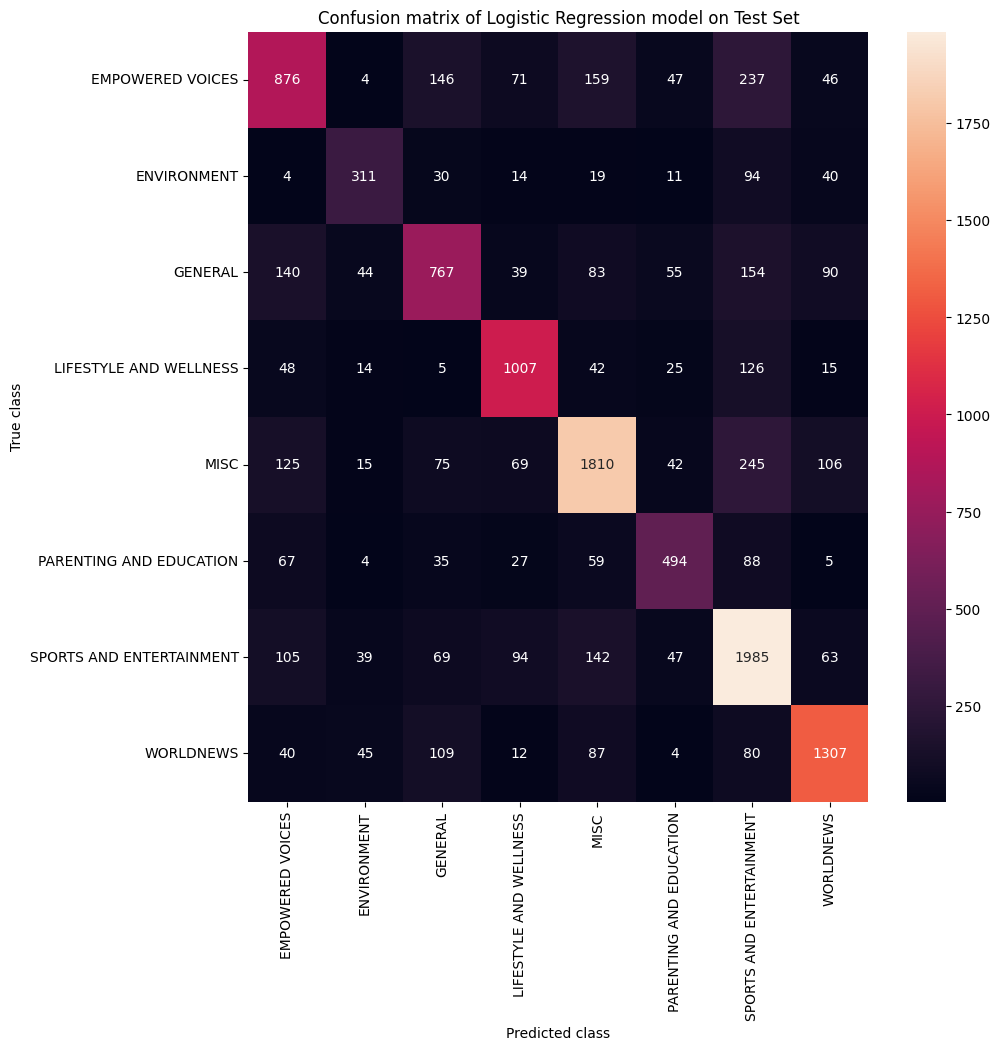

In [23]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
#chat gpt

# Assuming y is your 1D array of string category labels
y_target = set(y_test)

# Step 1: Use LabelEncoder to convert string labels to integer IDs
label_encoder = LabelEncoder()
y_train_simple = label_encoder.fit_transform(y_train)
y_test_simple = label_encoder.fit_transform(y_test)

# Print the results
print("Original labels:", y_target)
print("Y_train: Encoded labels (integer IDs):", y_train_simple)
print("Y_test: Encoded labels (integer IDs):", y_test_simple)

#chat gpt
encoder_mappings = {
    'class_labels': label_encoder.classes_.tolist(),
    'integer_to_label': dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_)),
    'label_to_integer': dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
}
print(encoder_mappings)

with open('drive/MyDrive/trials/label_encoder_mappings.pkl', 'wb') as file:
    pickle.dump(encoder_mappings, file)

In [26]:
from sklearn.linear_model import LogisticRegression

# Assuming the Sequencer class is defined as provided in your previous code

# Initialize Sequencer with the necessary parameters
sequencer = Sequencer(all_words=[token for seq in X for token in seq], max_vocab_words=20000, embedding_matrix=pre_trained_model_wv)

# Convert text data into vectors using Sequencer
x_train_vecs = np.asarray([sequencer.textToVector(tokens) for tokens in X_train])
x_test_vecs = np.asarray([sequencer.textToVector(tokens) for tokens in X_test])

# Train Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=42)
logistic_regression_model.fit(x_train_vecs, y_train_simple)

# Evaluate Logistic Regression Model on Test Set
test_pred = logistic_regression_model.predict(x_test_vecs)

# Confusion Matrix and Classification Report for Logistic Regression Model on Test Set
print(classification_report(y_test_simple, test_pred))
cf_matrix_test = confusion_matrix(y_test_simple, test_pred)

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(10,10))
heatmap_test = sns.heatmap(cf_matrix_test, xticklabels=label_encoder.classes_,
                           yticklabels=label_encoder.classes_,
                           annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of Logistic Regression model on Test Set')
plt.show()


Logistic Regression model saved at: drive/MyDrive/logistic_regression_model.pickle


In [ ]:
import pickle
model_save_path = 'drive/MyDrive/logistic_regression_model.pickle'

with open(model_save_path, 'wb') as handle:
    pickle.dump(logistic_regression_model, handle)

print(f"Logistic Regression model saved at: {model_save_path}")